### Descripción de los datos
Se tiene una base de datos de ECG de 12 derivaciones de 28 atletas de alto rendimiento de Noruega. Debido a la baja cantidad de datos se optó por expandir la cantidad de datos, para esto se usó “Lobachevsky University Electrocardiography Database”. Esta base de datos contiene 200 ECG de 12 derivaciones de personas que no son necesariamente deportistas, y para utilizar estos datos en un enfoque para detectar anomalías en deportistas, solo se considera los datos de los pacientes hasta 45 años, por lo que finalmente se tienen 69 pacientes de la nueva base de datos.

Las bases de datos tienen diferencias entre el formato del diagnóstico. En la BD de deportistas, las etiquetas se presentan en un listado, donde primero se indica el tipo de ritmo, posterior a esto se agregan si es que existen anomalías cardíacas, y finalmente se indica el diagnóstico general del ECG, si es normal o de riesgo. En el caso de la BD de Lobachevsky University, se indica el tipo de ritmo cardiaco, el eje eléctrico del corazón y se agregan si es que existen anomalías, en este caso no indica el diagnóstico general del ECG.

In [2]:
#%pip install wfdb

import numpy as np
import wfdb

def standardize_ecg(ecg_data, file_name):
    # Normalizar los valores de voltaje a un rango de 0 a 1
    ecg_data_normalized = (ecg_data - np.min(ecg_data)) / (np.max(ecg_data) - np.min(ecg_data))
    target_sampling_rate = 500  
    
    record = wfdb.rdsamp(file_name)
    original_sampling_rate = record[1]['fs']
    
    if original_sampling_rate != target_sampling_rate:
        num_samples = int(len(ecg_data_normalized) * target_sampling_rate / original_sampling_rate)
        x_old = np.linspace(0, len(ecg_data_normalized), len(ecg_data_normalized))
        x_new = np.linspace(0, len(ecg_data_normalized), num_samples)
        ecg_data_standardized = np.interp(x_new, x_old, ecg_data_normalized)
    else:
        ecg_data_standardized = ecg_data_normalized

    return ecg_data_standardized

In [3]:
import wfdb
import numpy as np
import os

directory = "./LUDB/"
ECGsLU = []
ECGsNoEstandarizados = []
lista = os.listdir(directory)
sorted_files = sorted(lista, key=lambda x: int(x.split('.')[0]))
for ecgfilename in sorted_files:
    if ecgfilename.endswith(".dat"):
        try:
            ecg = wfdb.rdsamp(directory + ecgfilename.split(".")[0])
            standardized_ecg = standardize_ecg(ecg[0], directory + ecgfilename.split(".")[0])  # Estandarizar
            ECGsLU.append(standardized_ecg) 
            ECGsNoEstandarizados.append(ecg[0])
        except Exception as e:
            print(f"Error al leer el archivo {ecgfilename}: {e}")
ECGsLU = np.asarray(ECGsLU)
print(len(ECGsLU))


200


In [4]:
import wfdb
import numpy as np
import os

directoryAtletas = "./NEADB/"
ECGsAtletas = []
ECGsAtletasNoEstandarizados = []
for ecgfilename in sorted(os.listdir(directoryAtletas)):
    if ecgfilename.endswith(".dat"):
        try:
            ecg = wfdb.rdsamp(directoryAtletas + ecgfilename.split(".")[0])
            standardized_ecg_atleta = standardize_ecg(ecg[0], directoryAtletas + ecgfilename.split(".")[0])  # Estandarizar
            ECGsAtletas.append(standardized_ecg_atleta) 
            ECGsAtletasNoEstandarizados.append(ecg[0])
        except Exception as e:
            print(f"Error al leer el archivo {ecgfilename}: {e}")
ECGsAtletas = np.asarray(ECGsAtletas)
print(len(ECGsAtletas))

28


In [42]:
#etiquetas a considerar
#Clasificar los ECGs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Leer las etiquetas de los ECGs, sin repetir
etiquestasCardiologosAtletas = []
etiquetaRiesgoDeportista = []
etiquetaRiesgoDeportistasSL12 = []
for ecgfilename in sorted(os.listdir(directoryAtletas)):
    # Solo leer los archivos .hea desde el ath_001 hasta el ath_019
    if ecgfilename.endswith(".hea"):
        with open(directoryAtletas + ecgfilename) as f:
            lines = f.readlines()
            diagnoses = []
            for line in lines:
                riesgos = 0
                if line.startswith("#C:"):
                    etiqueta = line.split(":")[1].strip()
                    etiquetas = etiqueta.split(", ")
                    for etiqueta in etiquetas:
                        etiqueta = etiqueta.lower()
                        if("ecg" not in etiqueta):
                            diagnoses.append(etiqueta)
                        else:
                            if(etiqueta == "borderline ecg"):
                                etiquetaRiesgoDeportista.append("ECG de riesgo")
                            elif(etiqueta == "normal ecg"):
                                etiquetaRiesgoDeportista.append("ECG normal")         
                        if(etiqueta == "right axis deviation"):
                            riesgos += 1
                        elif(etiqueta == "left axis deviation"):
                            riesgos += 1
                        elif(etiqueta == "left atrial enlargement"):
                            riesgos += 1
                    etiquestasCardiologosAtletas.append(diagnoses)

                elif line.startswith("#SL12:"):
                    etiqueta = line.split("#SL12:")[1].strip()
                    etiquetas = etiqueta.split(", ")
                    for etiqueta in etiquetas:
                        etiqueta = etiqueta.lower()
                        if("abnormal ecg" == etiqueta):
                            etiquetaRiesgoDeportistasSL12.append("ECG de riesgo")
                            agrego=1             
                            break
                        elif("normal ecg" in etiqueta):
                            etiquetaRiesgoDeportistasSL12.append("ECG normal")
                        elif("ecg" in etiqueta):
                            etiquetaRiesgoDeportistasSL12.append("ECG de riesgo")

                    
                    
                    


#imprimir las etiquetas de los atletas
for i in range(len(etiquestasCardiologosAtletas)):
    print(f"Etiquetas del atleta {i + 1}: {etiquestasCardiologosAtletas[i]}")

print(etiquetaRiesgoDeportista)
print(etiquetaRiesgoDeportistasSL12)
print(len(etiquetaRiesgoDeportistasSL12))



Etiquetas del atleta 1: ['sinus arrhythmia']
Etiquetas del atleta 2: ['sinus arrhythmia', 'right axis deviation']
Etiquetas del atleta 3: ['normal sinus rhythm', 'left axis deviation']
Etiquetas del atleta 4: ['normal sinus rhythm']
Etiquetas del atleta 5: ['sinus bradycardia', 'normal sinus rhythm', 'first degree av block']
Etiquetas del atleta 6: ['normal sinus rhythm', 'left ventricular hypertrophy']
Etiquetas del atleta 7: ['normal sinus rhythm']
Etiquetas del atleta 8: ['normal sinus rhythm', 'incomplete right bundle branch block']
Etiquetas del atleta 9: ['normal sinus rhythm', 'right axis deviation', 'first degree av block']
Etiquetas del atleta 10: ['normal sinus rhythm', 'left ventricular hypertrophy', 'left atrial enlargement']
Etiquetas del atleta 11: ['sinus arrhythmia']
Etiquetas del atleta 12: ['sinus arrhythmia']
Etiquetas del atleta 13: ['sinus bradycardia']
Etiquetas del atleta 14: ['normal sinus rhythm']
Etiquetas del atleta 15: ['normal sinus rhythm']
Etiquetas del a

In [6]:
#Filtrar datos para utilizar con la bd de deportistas
etiquestasCardiologos = []
ages = []
ECGsFiltrados = []
etiquetaRiesgoLU = []
for ecgfilename in sorted_files:
    if ecgfilename.endswith(".hea"):
        with open(directory + ecgfilename) as f:
            lines = f.readlines()
            diagnoses = []
            for line in lines:
                line = line.lower()
                if line.startswith("#<age>:"):
                    #si la edad es mayor a 45 años no se considera
                    if int(line.split(":")[1].strip()) <= 45:
                        ages.append(line.split(":")[1].strip())
                        try:
                            ecg = wfdb.rdsamp(directory + ecgfilename.split(".")[0])
                            standardized_ecg = standardize_ecg(ecg[0], directory + ecgfilename.split(".")[0])  # Estandarizar
                            ECGsFiltrados.append(standardized_ecg) 
                        except Exception as e:
                            print(f"Error al leer el archivo {ecgfilename}: {e}")
                    else:
                        break
                elif line.startswith("#<diagnoses>"):
                    riesgosBorderline = 0
                    for line in lines[lines.index("#<diagnoses>:\n")+1:]:
                        line = line.lower()
                        line = line.split(".")[0].lower()
                        if line.startswith("#rhythm"):
                            line = line.split(": ")[1].strip()         
                            diagnoses.append(line)

                        elif line.startswith("#electric axis of the heart:"):
                            line = line.split(": ")[1].strip()
                            if line == "vertical" or line == "horizontal" or line == "normal":
                                diagnoses.append("normal axis")
                            else:
                                diagnoses.append(line)
                                riesgosBorderline += 1
                        elif "degree" in line:
                            line = line.split(".")[0].strip()
                            line = line.split("#")[1].strip()
                            diagnoses.append(line)
                        elif "left ventricular" in line:
                            line = line.split(".")[0].strip()
                            line = line.split("#")[1].strip()
                            diagnoses.append(line)
                        elif "left atrial " in line:
                            line = line.split("#")[1].strip()
                            diagnoses.append(line)
                            riesgosBorderline += 1
                        elif "complete right bundle branch block" in line:
                            line = line.split("#")[1].strip()
                            if(line == "complete right bundle branch block"):
                                riesgosBorderline += 1
                            diagnoses.append(line)
                        elif "right atrial " in line:
                            line = line.split("#")[1].strip()
                            diagnoses.append(line)
                            riesgosBorderline += 1
                        elif "ischemia" in line:
                            diagnoses.append("ischemia")
                            riesgosBorderline += 2
                        #else: 
                            #diagnoses.append(line)            
                    etiquestasCardiologos.append(diagnoses)

                    if(riesgosBorderline >1):
                        etiquetaRiesgoLU.append("ECG de riesgo")
                    else:
                        etiquetaRiesgoLU.append("ECG normal")

                    
#cantidad de edades menores de 50 años
cantidadEdades = 0
for i in range(len(ages)):
    if int(ages[i]) <= 45:
        cantidadEdades += 1
print(f"La cantidad de edades menores a 45 años es: {cantidadEdades}")

#contar los de riesgo y los normales
cantidadRiesgo = 0
cantidadNormal = 0

for i in range(len(etiquetaRiesgoLU)):
    if etiquetaRiesgoLU[i] == "ECG de riesgo":
        cantidadRiesgo += 1
    else:
        cantidadNormal += 1

print(f"La cantidad de ECGs de riesgo es: {cantidadRiesgo}")
print(f"La cantidad de ECGs normales es: {cantidadNormal}")
        


La cantidad de edades menores a 45 años es: 69
La cantidad de ECGs de riesgo es: 11
La cantidad de ECGs normales es: 58


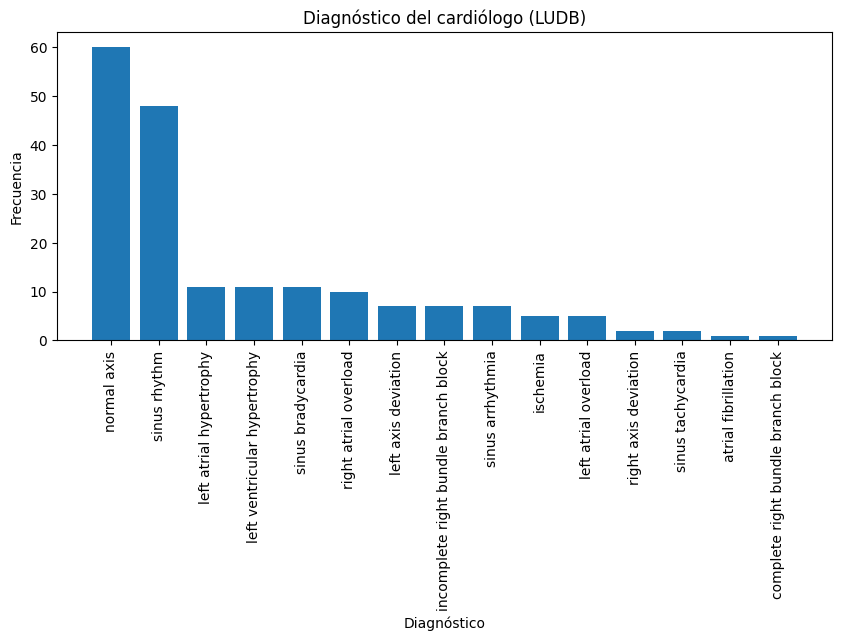

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

all_diagnoses = [item for sublist in etiquestasCardiologos for item in sublist]
counter = Counter(all_diagnoses)
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 4))
plt.bar(counter.keys(), counter.values())
plt.title('Diagnóstico del cardiólogo (LUDB)')
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

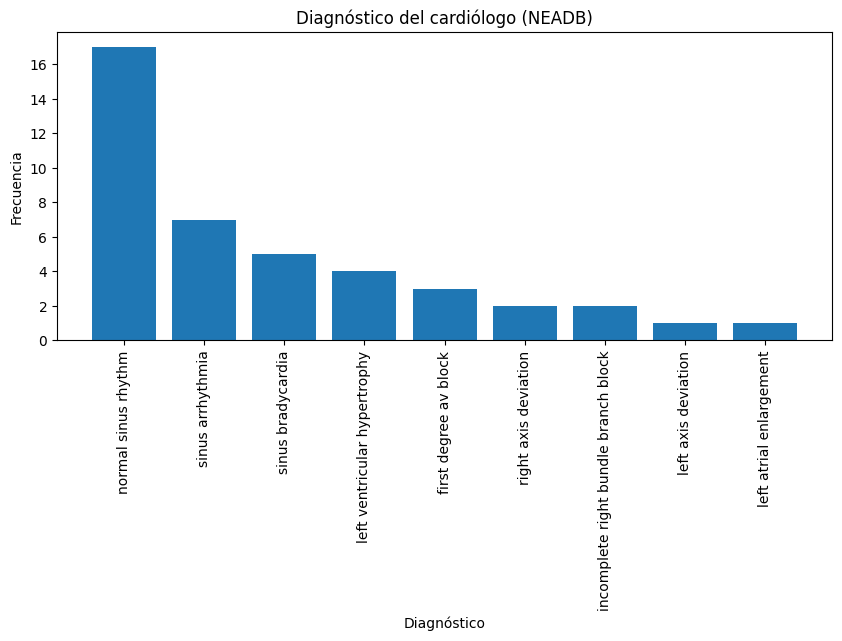

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

all_diagnoses = [item for sublist in etiquestasCardiologosAtletas for item in sublist]
counter = Counter(all_diagnoses)
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 4))
plt.bar(counter.keys(), counter.values())
plt.title('Diagnóstico del cardiólogo (NEADB)')
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

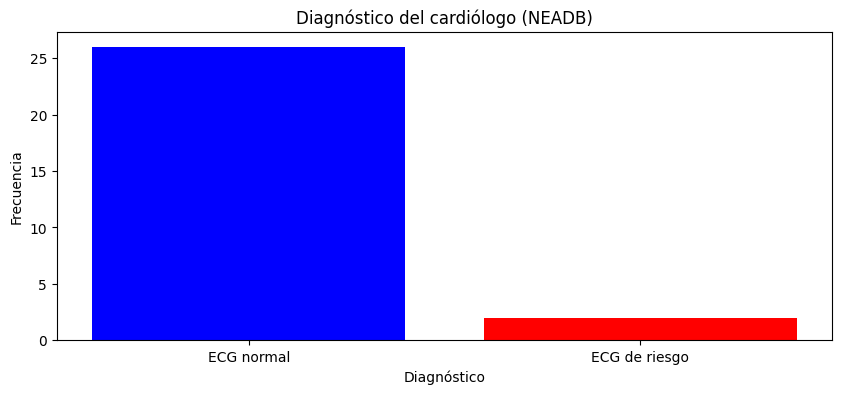

In [9]:
#grafico de las frecuencias de cada etiqueta de ecg

import matplotlib.pyplot as plt
from collections import Counter

counter = Counter(etiquetaRiesgoDeportista)
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 4))
colors = ['red' if label == 'ECG de riesgo' else 'blue' for label in counter.keys()]
plt.bar(counter.keys(), counter.values(), color=colors)
plt.title('Diagnóstico del cardiólogo (NEADB)')
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.show()


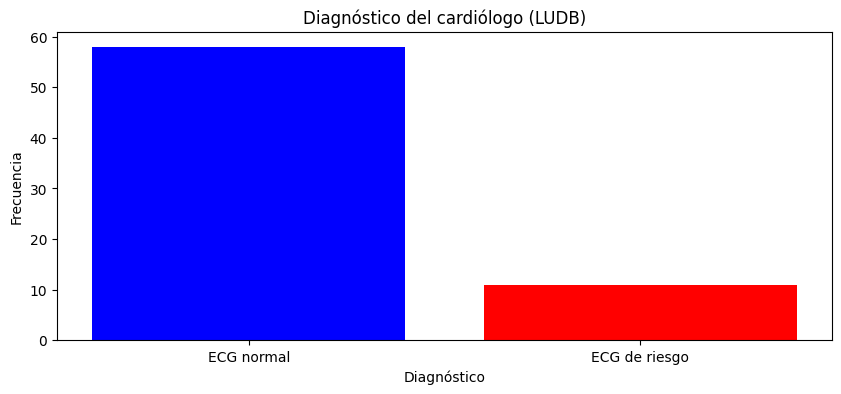

In [10]:
#grafico de las frecuencias de cada etiqueta de ecg de LUDB

import matplotlib.pyplot as plt
from collections import Counter

counter = Counter(etiquetaRiesgoLU)
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 4))
colors = ['red' if label == 'ECG de riesgo' else 'blue' for label in counter.keys()]
plt.bar(counter.keys(), counter.values(), color=colors)
plt.title('Diagnóstico del cardiólogo (LUDB)')
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.show()

c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


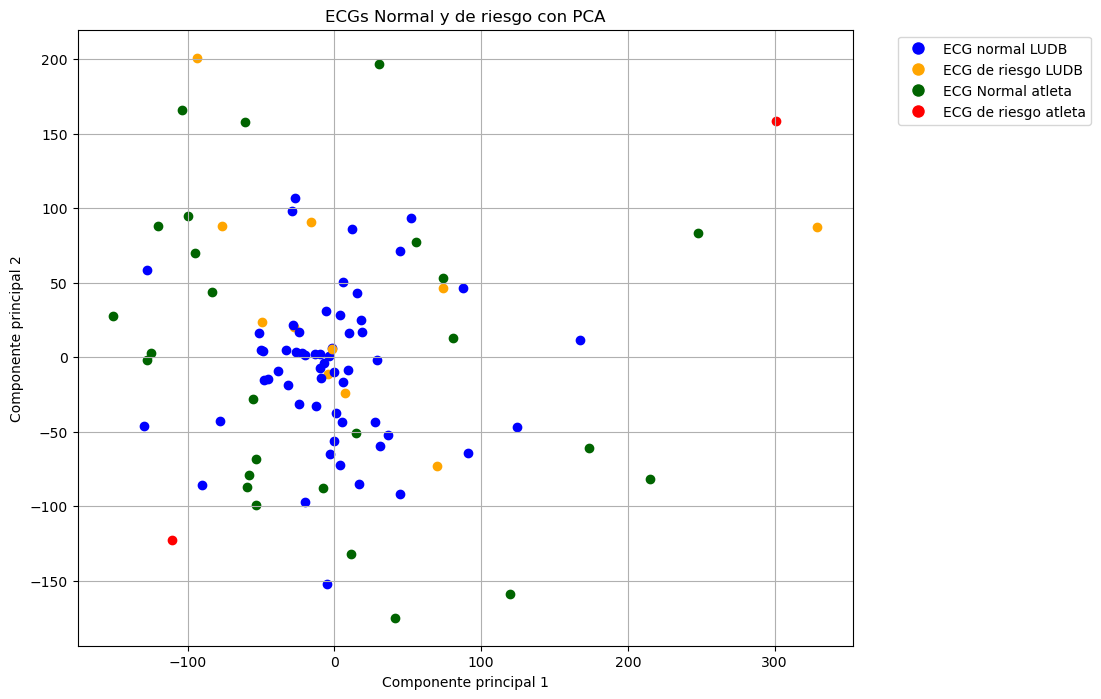

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

# Normalizar los ECGs
scaler = StandardScaler()
normalized_ECGs = scaler.fit_transform([ecg.flatten() for ecg in ECGsFiltrados])

# Reducir la dimensionalidad de los ECGs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_ECGs)

# Normalizar los ECGs de los atletas
scalerD = StandardScaler()
normalized_ECGsD = scalerD.fit_transform([ecg.flatten() for ecg in ECGsAtletas])

# Reducir la dimensionalidad de los ECGs de atletas
pcaD = PCA(n_components=2)
principal_componentsD = pcaD.fit_transform(normalized_ECGsD)

# Clasificar los ECGs por etiquetas
kmeans = KMeans(n_clusters=2)
kmeans.fit(principal_components)

# Clasificar los ECGs de los atletas por etiquetas
kmeansD = KMeans(n_clusters=2)
kmeansD.fit(principal_componentsD)

# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 8))

label_color_map = {'ECG normal': 'green', 'ECG de riesgo': 'yellow'}

# Graficar cada punto para los ECGs
for i, (x, y) in enumerate(principal_components):
    labels = etiquetaRiesgoLU[i]
    if 'ECG normal' in labels:
        plt.scatter(x, y, color='blue', label='ECG normal' if i == 0 else "")
    if 'ECG de riesgo' in labels:
        plt.scatter(x, y, color='orange', label='ECG de riesgo' if i == 0 else "")

# Graficar cada punto para los ECGs de los atletas
for i, (x, y) in enumerate(principal_componentsD):
    labels = etiquetaRiesgoDeportista[i]
    if 'ECG normal' in labels:
        plt.scatter(x, y, color='darkgreen', label='ECG normal atleta' if i == 0 else "")
    if 'ECG de riesgo' in labels:
        plt.scatter(x, y, color='red', label='ECG de riesgo atleta' if i == 0 else "")

# Crear la leyenda para las 2 bases de datos
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='ECG normal LUDB'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='ECG de riesgo LUDB'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=10, label='ECG Normal atleta'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='ECG de riesgo atleta')
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('ECGs Normal y de riesgo con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid()
plt.show()



In [ ]:
#%pip install fastdtw

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import json
from collections import Counter

json_file_path = 'diagnosticos_ecgs_k7_vMayor.json'
with open(json_file_path, 'w') as f:
    json.dump({}, f)

diagnosticos_finales = {}

# Función para obtener el diagnóstico final basado en K vecinos más cercanos (KNN)
def diagnostico_dtw(distancias_diagnostico, k=3, v=1):
    # Obtener las k etiquetas de los k vecinos más cercanos
    vecinos_mas_cercanos = [etiqueta for _, etiqueta in distancias_diagnostico[:k]]

    if(v == 1):
        # Verificar si algún vecino cercano es "ECG de riesgo"
        if "ECG de riesgo" in vecinos_mas_cercanos:
            return "ECG de riesgo"
        else:
            return "ECG normal"
    
    # Contar las frecuencias de las etiquetas
    counter = Counter(vecinos_mas_cercanos)

    # Obtener la etiqueta con mayor frecuencia
    diagnostico_final = counter.most_common(1)[0][0]
    
    return diagnostico_final
    
    
# Evaluar todos los ECGs de los atletas
for index, nuevo_ecg in enumerate(ECGsAtletas):
    distancias_diagnostico = []
    
    # Calcular las distancias DTW entre el nuevo ECG y los ECGs filtrados
    for i, ecg in enumerate(ECGsFiltrados):
        distancia, _ = fastdtw(nuevo_ecg, ecg, dist=euclidean)
        distancias_diagnostico.append((distancia, etiquetaRiesgoLU[i]))

    # Ordenar por distancia para obtener los ECGs más cercanos
    distancias_diagnostico.sort(key=lambda x: x[0])

    # Obtener el diagnóstico final utilizando K vecinos más cercanos (KNN)
    diagnostico_final = diagnostico_dtw(distancias_diagnostico, k=3)
    diagnosticos_finales[f'Atleta_{index}'] = diagnostico_final
    print(f"Diagnóstico del ECG del Atleta {index}: {diagnostico_final}")

    # Guarda cada diagnostico
    with open(f'./diagnosticos/diagnostico_atleta_{index}.txt', 'w') as text_file:
        text_file.write("El diagnóstico final del ECG es: " + diagnostico_final)

    # Guardar el diagnóstico final en un archivo JSON
    with open(json_file_path, 'r+') as json_file:
        data = json.load(json_file)
        data[f'Atleta_{index}'] = diagnostico_final
        json_file.seek(0)
        json.dump(data, json_file, indent=4)
        json_file.truncate() 
        



Diagnóstico del ECG del Atleta 0: ECG normal
Diagnóstico del ECG del Atleta 1: ECG normal
Diagnóstico del ECG del Atleta 2: ECG normal
Diagnóstico del ECG del Atleta 3: ECG normal
Diagnóstico del ECG del Atleta 4: ECG normal
Diagnóstico del ECG del Atleta 5: ECG normal
Diagnóstico del ECG del Atleta 6: ECG normal
Diagnóstico del ECG del Atleta 7: ECG normal
Diagnóstico del ECG del Atleta 8: ECG normal
Diagnóstico del ECG del Atleta 9: ECG normal
Diagnóstico del ECG del Atleta 10: ECG normal
Diagnóstico del ECG del Atleta 11: ECG normal
Diagnóstico del ECG del Atleta 12: ECG normal
Diagnóstico del ECG del Atleta 13: ECG normal
Diagnóstico del ECG del Atleta 14: ECG normal
Diagnóstico del ECG del Atleta 15: ECG normal
Diagnóstico del ECG del Atleta 16: ECG normal
Diagnóstico del ECG del Atleta 17: ECG normal
Diagnóstico del ECG del Atleta 18: ECG normal
Diagnóstico del ECG del Atleta 19: ECG normal
Diagnóstico del ECG del Atleta 20: ECG normal
Diagnóstico del ECG del Atleta 21: ECG norma

In [44]:
#matriz de confusion de los atletas
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import json
# Cargar etiquetas predichas
with open('diagnosticos_ecgs_k3_v1.json', 'r') as f:
    diagnosticos_finales = json.load(f)

# Definir las etiquetas verdaderas y predichas
etiquetas_verdaderas = etiquetaRiesgoDeportista.copy()
etiquetas_predichas = list(diagnosticos_finales.values()).copy()

#calcular la exactitud
exactitudDTW = accuracy_score(etiquetas_verdaderas, etiquetas_predichas)
print(f"La exactitud del modelo es: {exactitudDTW * 100:.2f}%")

#calcular recall y precision

precisionDTW = precision_score(etiquetas_verdaderas, etiquetas_predichas, pos_label="ECG de riesgo")
recallDTW = recall_score(etiquetas_verdaderas, etiquetas_predichas, pos_label="ECG de riesgo")

print(f"La precisión del modelo es: {precisionDTW * 100:.2f}%")
print(f"El recall del modelo es: {recallDTW * 100:.2f}%")

f1DTW = f1_score(etiquetas_verdaderas, etiquetas_predichas, pos_label="ECG de riesgo")
print(f"El puntaje F1 del modelo es: {f1DTW * 100:.2f}%")






La exactitud del modelo es: 85.71%
La precisión del modelo es: 33.33%
El recall del modelo es: 100.00%
El puntaje F1 del modelo es: 50.00%


In [57]:
#funcion que calcula estadisticas de los ecgs para usar en el modelo
def calcular_estadisticas_ecg(ecg):
    # Calcular la media, desviación estándar, valor máximo y valor mínimo
    media = np.mean(ecg)
    desviacion_estandar = np.std(ecg)
    maximo = np.max(ecg)
    minimo = np.min(ecg)
    
    return [media, desviacion_estandar, maximo, minimo]

# Calcular las estadísticas de los ECGs
estadisticas_ECGs = np.array([calcular_estadisticas_ecg(ecg) for ecg in ECGsFiltrados])
estadisticas_ECGsAtletas = np.array([calcular_estadisticas_ecg(ecg) for ecg in ECGsAtletas])



In [67]:
#entrenar modelo de desicion tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Crear el modelo de árbol de decisión
tree = DecisionTreeClassifier(random_state=42)

# Aplanar los datos de ECGs
ECGsFiltrados_flat = [ecg.flatten() for ecg in ECGsFiltrados]
ECGsAtletas_flat = [ecg.flatten() for ecg in ECGsAtletas]

# Entrenar el modelo
tree.fit(estadisticas_ECGs, etiquetaRiesgoLU)

# Predecir las etiquetas de los datos de prueba
etiquetas_predichasDT = tree.predict(estadisticas_ECGsAtletas)

# mostrar las etiquetas predichas
print(etiquetas_predichasDT)

# Calcular la exactitud del modelo
exactitudDT = accuracy_score(etiquetaRiesgoDeportista, etiquetas_predichasDT)
print(f"La exactitud del modelo es: {exactitudDT * 100:.2f}%")

#calcular recall y precision
precisionDT = precision_score(etiquetaRiesgoDeportista, etiquetas_predichasDT, pos_label="ECG de riesgo")
recallDT = recall_score(etiquetaRiesgoDeportista, etiquetas_predichasDT, pos_label="ECG de riesgo")
f1DT = f1_score(etiquetaRiesgoDeportista, etiquetas_predichasDT, pos_label="ECG de riesgo")

print(f"La precisión del modelo es: {precisionDT * 100:.2f}%")
print(f"El recall del modelo es: {recallDT * 100:.2f}%")
print(f"El puntaje F1 del modelo es: {f1DT * 100:.2f}%")


['ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo']
La exactitud del modelo es: 7.14%
La precisión del modelo es: 7.14%
El recall del modelo es: 100.00%
El puntaje F1 del modelo es: 13.33%


In [68]:
#entrenar modelo de naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Crear el modelo de Naive Bayes
naive_bayes = GaussianNB()

# Aplanar los datos de ECGs
ECGsFiltrados_flat = [ecg.flatten() for ecg in ECGsFiltrados]
ECGsAtletas_flat = [ecg.flatten() for ecg in ECGsAtletas]

# Entrenar el modelo
naive_bayes.fit(estadisticas_ECGs, etiquetaRiesgoLU)

# Predecir las etiquetas de los datos de prueba
etiquetas_predichasNB = naive_bayes.predict(estadisticas_ECGsAtletas)

# Calcular la exactitud del modelo
exactitudNB = accuracy_score(etiquetaRiesgoDeportista, etiquetas_predichasNB)
print(f"La exactitud del modelo es: {exactitudNB * 100:.2f}%")

#calcular recall y precision
precisionNB = precision_score(etiquetaRiesgoDeportista, etiquetas_predichasNB, pos_label="ECG de riesgo")
recallNB = recall_score(etiquetaRiesgoDeportista, etiquetas_predichasNB, pos_label="ECG de riesgo")
f1NB = f1_score(etiquetaRiesgoDeportista, etiquetas_predichasNB, pos_label="ECG de riesgo")

print(f"La precisión del modelo es: {precisionNB * 100:.2f}%")
print(f"El recall del modelo es: {recallNB * 100:.2f}%")
print(f"El puntaje F1 del modelo es: {f1NB * 100:.2f}%")

#mostrar las etiquetas predichas
print(etiquetas_predichasNB)


La exactitud del modelo es: 7.14%
La precisión del modelo es: 7.14%
El recall del modelo es: 100.00%
El puntaje F1 del modelo es: 13.33%
['ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo'
 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo' 'ECG de riesgo']


In [69]:
#entrenar modelo svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Crear el modelo de SVM
svm = SVC()

# Aplanar los datos de ECGs
ECGsFiltrados_flat = [ecg.flatten() for ecg in ECGsFiltrados]
ECGsAtletas_flat = [ecg.flatten() for ecg in ECGsAtletas]

# Entrenar el modelo
svm.fit(estadisticas_ECGs, etiquetaRiesgoLU)

# Predecir las etiquetas de los datos de prueba
etiquetas_predichasSVM = svm.predict(estadisticas_ECGsAtletas)

# Calcular la exactitud del modelo
exactitudSVM = accuracy_score(etiquetaRiesgoDeportista, etiquetas_predichasSVM)
print(f"La exactitud del modelo es: {exactitudSVM * 100:.2f}%")

#calcular recall y precision
precisionSVM = precision_score(etiquetaRiesgoDeportista, etiquetas_predichasSVM, pos_label="ECG de riesgo")
recallSVM = recall_score(etiquetaRiesgoDeportista, etiquetas_predichasSVM, pos_label="ECG de riesgo")
f1SVM = f1_score(etiquetaRiesgoDeportista, etiquetas_predichasSVM, pos_label="ECG de riesgo")

print(f"La precisión del modelo es: {precisionSVM * 100:.2f}%")
print(f"El recall del modelo es: {recallSVM * 100:.2f}%")
print(f"El puntaje F1 del modelo es: {f1SVM * 100:.2f}%")

#mostrar las etiquetas predichas
print(etiquetas_predichasSVM)

La exactitud del modelo es: 92.86%
La precisión del modelo es: 0.00%
El recall del modelo es: 0.00%
El puntaje F1 del modelo es: 0.00%
['ECG normal' 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal'
 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal'
 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal'
 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal'
 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal'
 'ECG normal' 'ECG normal' 'ECG normal']


c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
#entrenar modelo de xgboost
#%pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

# Crear el modelo de XGBoost
xgboost = XGBClassifier()

# Aplanar los datos de ECGs
ECGsFiltrados_flat = [ecg.flatten() for ecg in ECGsFiltrados]
ECGsAtletas_flat = [ecg.flatten() for ecg in ECGsAtletas]

# Codificar las etiquetas
label_encoder = LabelEncoder()
etiquetaRiesgoLU_encoded = label_encoder.fit_transform(etiquetaRiesgoLU)
etiquetaRiesgoDeportista_encoded = label_encoder.transform(etiquetaRiesgoDeportista)

# Entrenar el modelo
xgboost.fit(estadisticas_ECGs, etiquetaRiesgoLU_encoded)

# Predecir las etiquetas de los datos de prueba
etiquetas_predichasXGB_encoded = xgboost.predict(estadisticas_ECGsAtletas)

# Decodificar las etiquetas predichas
etiquetas_predichasXGB = label_encoder.inverse_transform(etiquetas_predichasXGB_encoded)

# Calcular la exactitud del modelo
exactitudXGB = accuracy_score(etiquetaRiesgoDeportista, etiquetas_predichasXGB)
print(f"La exactitud del modelo es: {exactitudXGB * 100:.2f}%")

#calcular recall y precision
precisionXGB = precision_score(etiquetaRiesgoDeportista, etiquetas_predichasXGB, pos_label="ECG de riesgo")
recallXGB = recall_score(etiquetaRiesgoDeportista, etiquetas_predichasXGB, pos_label="ECG de riesgo")
f1XGB = f1_score(etiquetaRiesgoDeportista, etiquetas_predichasXGB, pos_label="ECG de riesgo")

print(f"La precisión del modelo es: {precisionXGB * 100:.2f}%")
print(f"El recall del modelo es: {recallXGB * 100:.2f}%")
print(f"El puntaje F1 del modelo es: {f1XGB * 100:.2f}%")

#mostrar las etiquetas predichas
print(etiquetas_predichasXGB)



La exactitud del modelo es: 78.57%
La precisión del modelo es: 16.67%
El recall del modelo es: 50.00%
El puntaje F1 del modelo es: 25.00%
['ECG de riesgo' 'ECG normal' 'ECG de riesgo' 'ECG de riesgo' 'ECG normal'
 'ECG normal' 'ECG de riesgo' 'ECG normal' 'ECG de riesgo' 'ECG normal'
 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal'
 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal'
 'ECG de riesgo' 'ECG normal' 'ECG normal' 'ECG normal' 'ECG normal'
 'ECG normal' 'ECG normal' 'ECG normal']


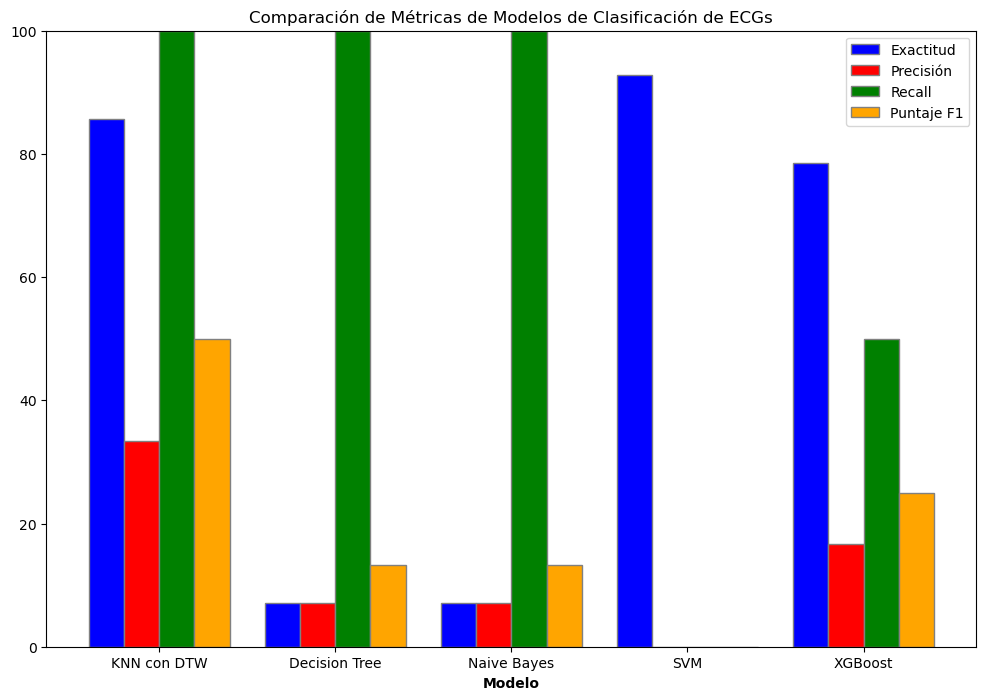

In [75]:
#comparar metricas entre los modelos
import matplotlib.pyplot as plt

# Crear un gráfico de barras para comparar las exactitudes, precisiones, recalls y puntajes F1
modelos = ['KNN con DTW', 'Decision Tree', 'Naive Bayes', 'SVM', 'XGBoost']
exactitudes = [exactitudDTW * 100, exactitudDT * 100, exactitudNB * 100, exactitudSVM * 100, exactitudXGB * 100]
precisiones = [precisionDTW * 100, precisionDT * 100, precisionNB * 100, precisionSVM * 100, precisionXGB * 100]
recalls = [recallDTW * 100, recallDT * 100, recallNB * 100, recallSVM * 100, recallXGB * 100]
f1s = [f1DTW * 100, f1DT * 100, f1NB * 100, f1SVM * 100, f1XGB * 100]

plt.figure(figsize=(12, 8))
barWidth = 0.2
r1 = range(len(modelos))

plt.bar(r1, exactitudes, color='blue', width=barWidth, edgecolor='grey', label='Exactitud')
plt.bar([x + barWidth for x in r1], precisiones, color='red', width=barWidth, edgecolor='grey', label='Precisión')
plt.bar([x + barWidth * 2 for x in r1], recalls, color='green', width=barWidth, edgecolor='grey', label='Recall')
plt.bar([x + barWidth * 3 for x in r1], f1s, color='orange', width=barWidth, edgecolor='grey', label='Puntaje F1')

plt.xlabel('Modelo', fontweight='bold')
plt.xticks([r + barWidth * 1.5 for r in range(len(modelos))], modelos)
plt.legend()
plt.title('Comparación de Métricas de Modelos de Clasificación de ECGs')
plt.ylim(0, 100)
plt.show()





In [46]:
#matriz de confusion de los atletas con SL12
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import json
# Cargar etiquetas predichas
with open('diagnosticos_ecgs.json', 'r') as f:
    diagnosticos_finales = json.load(f)

# Definir las etiquetas verdaderas y predichas
etiquetas_verdaderasConSL12 = etiquetaRiesgoDeportista.copy()
etiquetas_predichasSL12 = list(diagnosticos_finales.values()).copy()

for i in range(len(etiquetas_predichasSL12)):
    if "ECG de riesgo" in etiquetas_predichasSL12[i] and not "ECG de riesgo" in etiquetas_verdaderas[i]:
        if not "ECG normal" == etiquetaRiesgoDeportistasSL12[i]:
            etiquetas_verdaderasConSL12[i] = "ECG de riesgo"

#calcular la exactitud
exactitudSL12 = accuracy_score(etiquetas_verdaderasConSL12, etiquetas_predichasSL12)
print(f"La exactitud del modelo es: {exactitudSL12 * 100:.2f}%")

#calcular recall y precision
precisionSL12 = precision_score(etiquetas_verdaderasConSL12, etiquetas_predichasSL12, pos_label="ECG de riesgo")
recallSL12 = recall_score(etiquetas_verdaderasConSL12, etiquetas_predichasSL12, pos_label="ECG de riesgo")

print(f"La precisión del modelo es: {precisionSL12 * 100:.2f}%")
print(f"El recall del modelo es: {recallSL12 * 100:.2f}%")

f1SL12 = f1_score(etiquetas_verdaderasConSL12, etiquetas_predichasSL12, pos_label="ECG de riesgo")
print(f"El puntaje F1 del modelo es: {f1SL12 * 100:.2f}%")


La exactitud del modelo es: 96.43%
La precisión del modelo es: 83.33%
El recall del modelo es: 100.00%
El puntaje F1 del modelo es: 90.91%


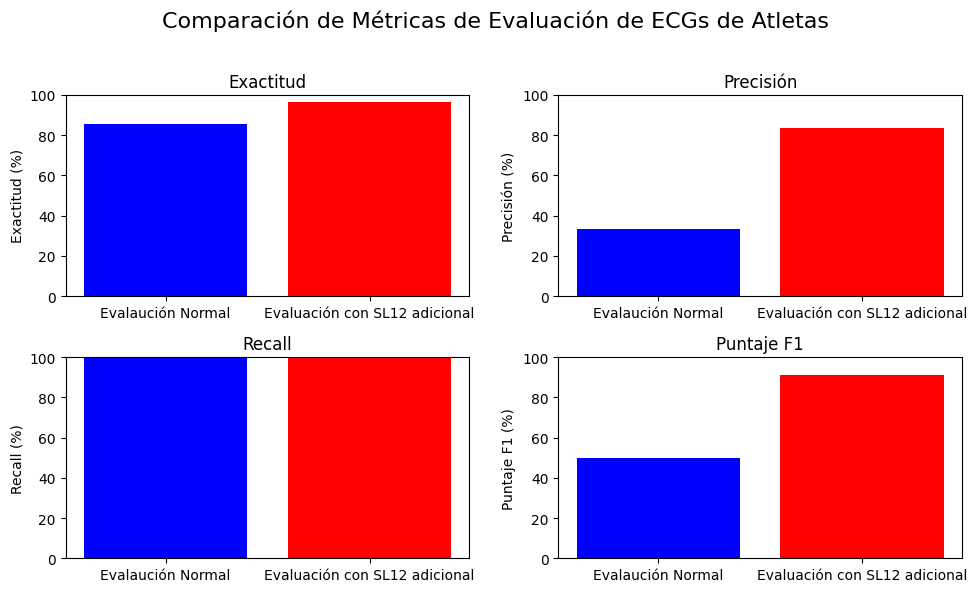

In [55]:
#comparacion de las metricas al usar la etiqueta SL12 en caso de falsos positivos

import matplotlib.pyplot as plt

# Definir las etiquetas de los modelos
modelos = ['Evalaución Normal', 'Evaluación con SL12 adicional']

# Crear un gráfico de barras para comparar las métricas
plt.figure(figsize=(10, 6))

# Titulo
plt.suptitle('Comparación de Métricas de Evaluación de ECGs de Atletas', fontsize=16)

# Exactitud
plt.subplot(2, 2, 1)
plt.bar(modelos, [exactitudDTW * 100, exactitudSL12 * 100], color=['blue', 'red'])
plt.title('Exactitud')
plt.ylabel('Exactitud (%)')
plt.ylim(0, 100)

# Precisión
plt.subplot(2, 2, 2)
plt.bar(modelos, [precisionDTW * 100, precisionSL12 * 100], color=['blue', 'red'])
plt.title('Precisión')
plt.ylabel('Precisión (%)')
plt.ylim(0, 100)

# Recall
plt.subplot(2, 2, 3)
plt.bar(modelos, [recallDTW * 100, recallSL12 * 100], color=['blue', 'red'])
plt.title('Recall')
plt.ylabel('Recall (%)')
plt.ylim(0, 100)

# Puntaje F1
plt.subplot(2, 2, 4)
plt.bar(modelos, [f1DTW * 100, f1SL12 * 100], color=['blue', 'red'])
plt.title('Puntaje F1')
plt.ylabel('Puntaje F1 (%)')
plt.ylim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

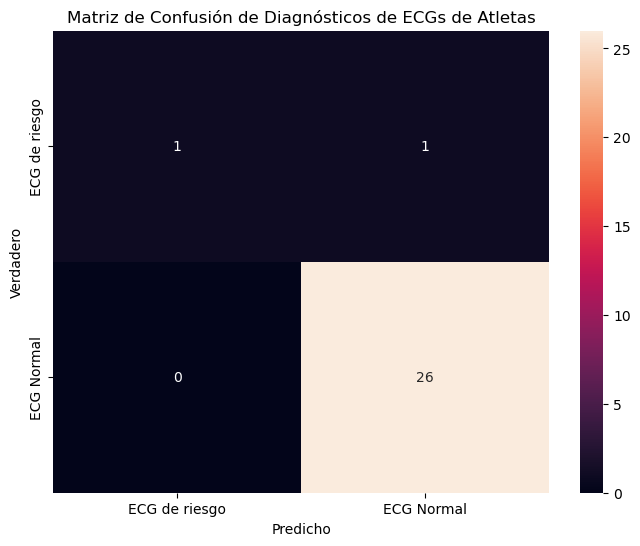

In [13]:
# Crear la matriz de confusión
cm = confusion_matrix(etiquetas_verdaderas, etiquetas_predichas)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[ "ECG de riesgo", "ECG Normal"], yticklabels=[ "ECG de riesgo", "ECG Normal"])
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión de Diagnósticos de ECGs de Atletas')
plt.show()

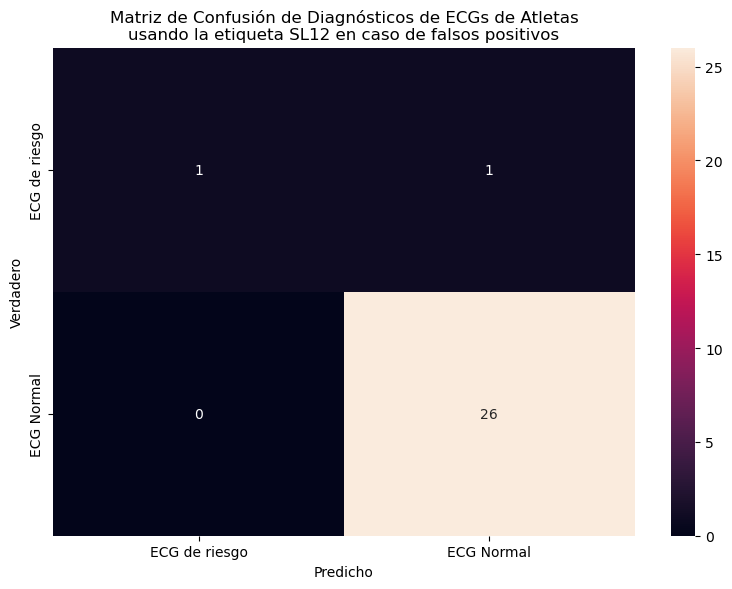

In [39]:
# Crear la matriz de confusión
cm = confusion_matrix(etiquetas_verdaderasConSL12, etiquetas_predichasSL12)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["ECG de riesgo", "ECG Normal"], yticklabels=["ECG de riesgo", "ECG Normal"])
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión de Diagnósticos de ECGs de Atletas\nusando la etiqueta SL12 en caso de falsos positivos')
plt.tight_layout()
plt.show()

c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


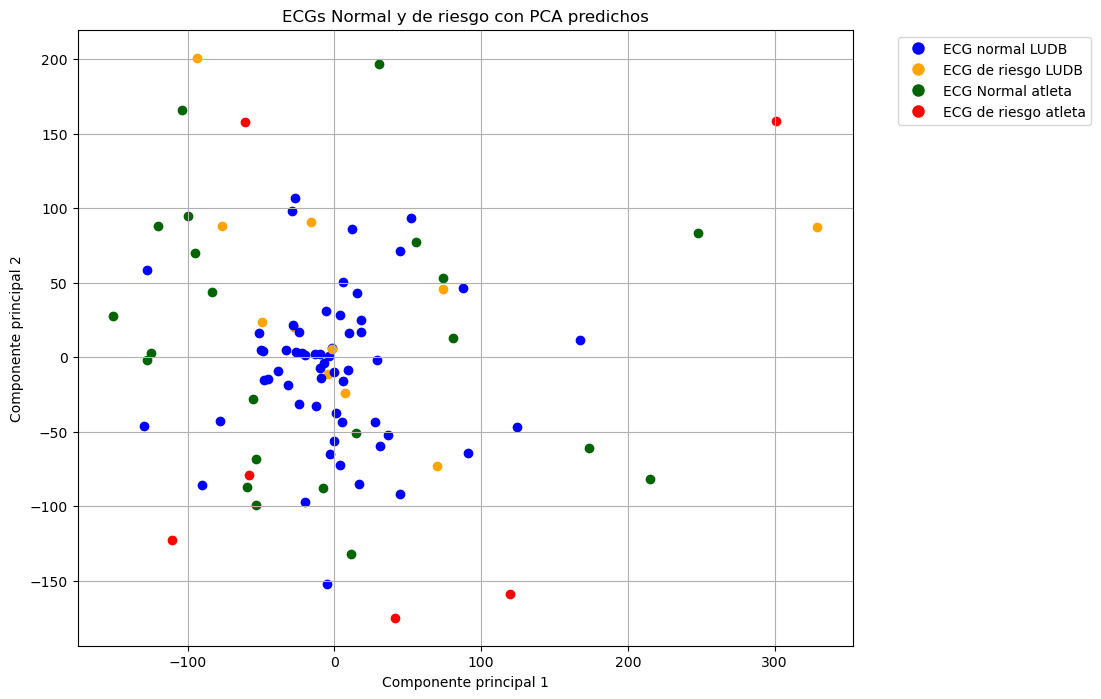

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

# Normalizar los ECGs
scaler = StandardScaler()
normalized_ECGs = scaler.fit_transform([ecg.flatten() for ecg in ECGsFiltrados])

# Reducir la dimensionalidad de los ECGs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_ECGs)

# Normalizar los ECGs de los atletas
scalerD = StandardScaler()
normalized_ECGsD = scalerD.fit_transform([ecg.flatten() for ecg in ECGsAtletas])

# Reducir la dimensionalidad de los ECGs de atletas
pcaD = PCA(n_components=2)
principal_componentsD = pcaD.fit_transform(normalized_ECGsD)

# Clasificar los ECGs por etiquetas
kmeans = KMeans(n_clusters=2)
kmeans.fit(principal_components)

# Clasificar los ECGs de los atletas por etiquetas
kmeansD = KMeans(n_clusters=2)
kmeansD.fit(principal_componentsD)

# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 8))

label_color_map = {'ECG normal': 'green', 'ECG de riesgo': 'yellow'}

# Graficar cada punto para los ECGs
for i, (x, y) in enumerate(principal_components):
    labels = etiquetaRiesgoLU[i]
    if 'ECG normal' in labels:
        plt.scatter(x, y, color='blue', label='ECG normal' if i == 0 else "")
    if 'ECG de riesgo' in labels:
        plt.scatter(x, y, color='orange', label='ECG de riesgo' if i == 0 else "")

# Graficar cada punto para los ECGs de los atletas
for i, (x, y) in enumerate(principal_componentsD):
    labels = etiquetas_predichas[i]
    if 'ECG normal' in labels:
        plt.scatter(x, y, color='darkgreen', label='ECG normal atleta' if i == 0 else "")
    if 'ECG de riesgo' in labels:
        plt.scatter(x, y, color='red', label='ECG de riesgo atleta' if i == 0 else "")

# Crear la leyenda para las 2 bases de datos
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='ECG normal LUDB'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='ECG de riesgo LUDB'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=10, label='ECG Normal atleta'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='ECG de riesgo atleta')
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('ECGs Normal y de riesgo con PCA predichos')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid()
plt.show()



c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


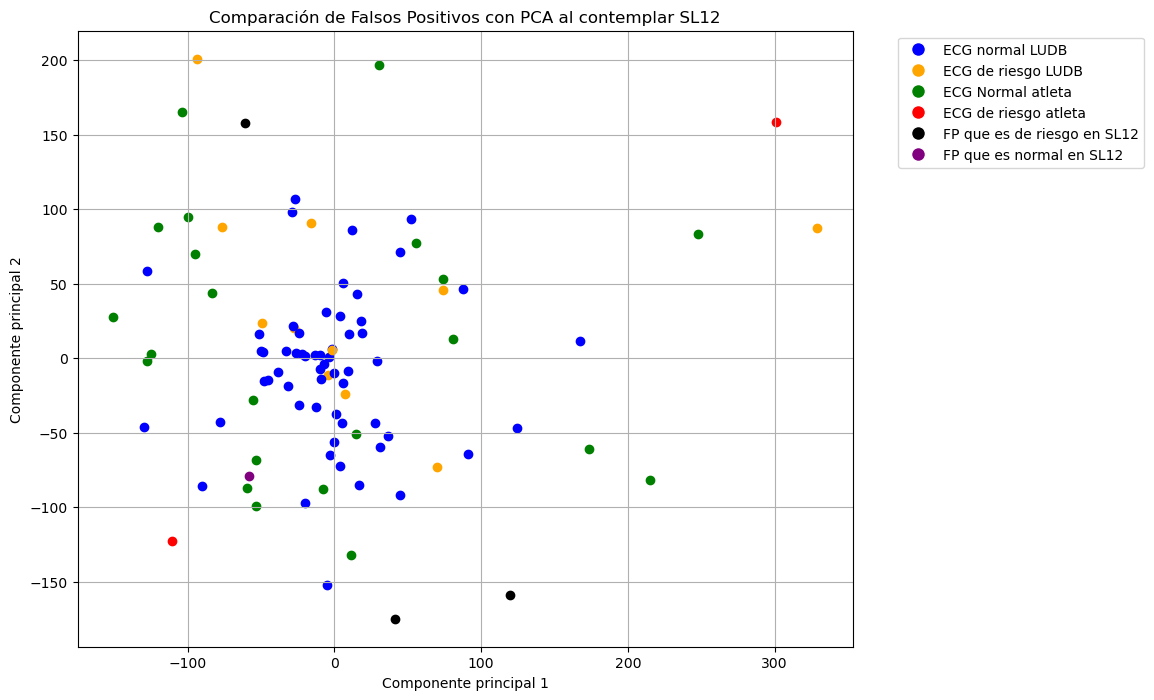

In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

# Normalizar los ECGs
scaler = StandardScaler()
normalized_ECGs = scaler.fit_transform([ecg.flatten() for ecg in ECGsFiltrados])

# Reducir la dimensionalidad de los ECGs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_ECGs)

# Normalizar los ECGs de los atletas
scalerD = StandardScaler()
normalized_ECGsD = scalerD.fit_transform([ecg.flatten() for ecg in ECGsAtletas])

# Reducir la dimensionalidad de los ECGs de atletas
pcaD = PCA(n_components=2)
principal_componentsD = pcaD.fit_transform(normalized_ECGsD)

# Clasificar los ECGs por etiquetas
kmeans = KMeans(n_clusters=2)
kmeans.fit(principal_components)

# Clasificar los ECGs de los atletas por etiquetas
kmeansD = KMeans(n_clusters=2)
kmeansD.fit(principal_componentsD)

# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 8))

label_color_map = {'ECG normal': 'green', 'ECG de riesgo': 'yellow', 'FP que si es de riesgo en SL12': 'black', 'FP que no es de riesgo en SL12': 'purple'}

etiquetasComparacion = etiquetas_predichas.copy()
#identificar falsos positivos que si son de riesgo en la etiqueta SL12
for i in range(len(etiquetasComparacion)):
    if "ECG de riesgo" in etiquetasComparacion[i] and not "ECG de riesgo" in etiquetas_verdaderas[i]:
        if not "ECG normal" == etiquetaRiesgoDeportistasSL12[i]:
            etiquetasComparacion[i] = "FP que es de riesgo en SL12"
        else:
            etiquetasComparacion[i] = "FP que es normal en SL12" 

# Graficar cada punto para los ECGs
for i, (x, y) in enumerate(principal_components):
    labels = etiquetaRiesgoLU[i]
    if 'ECG normal' in labels:
        plt.scatter(x, y, color='blue', label='ECG normal' if i == 0 else "")
    if 'ECG de riesgo' in labels:
        plt.scatter(x, y, color='orange', label='ECG de riesgo' if i == 0 else "")

# Graficar cada punto para los ECGs de los atletas
for i, (x, y) in enumerate(principal_componentsD):
    labels = etiquetasComparacion[i]
    if 'ECG normal' in labels:
        plt.scatter(x, y, color='green', label='ECG normal atleta' if i == 0 else "")
    if 'ECG de riesgo' in labels:
        plt.scatter(x, y, color='red', label='ECG de riesgo atleta' if i == 0 else "")
    if 'FP que es de riesgo en SL12' in labels:
        plt.scatter(x, y, color='black', label='FP que es de riesgo en SL12' if i == 0 else "")
    if 'FP que es normal en SL12' in labels:
        plt.scatter(x, y, color='purple', label='FP que es normal en SL12' if i == 0 else "")

# Crear la leyenda para las 2 bases de datos
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='ECG normal LUDB'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='ECG de riesgo LUDB'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='ECG Normal atleta'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='ECG de riesgo atleta'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='FP que es de riesgo en SL12'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='FP que es normal en SL12')
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Comparación de Falsos Positivos con PCA al contemplar SL12')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid()
plt.show()



In [77]:
#comparacion de implementacion de KNN


#matriz de confusion de los atletas
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json


def obtener_metricas(etiquetas_verdaderas, nombre_archivo, comparar_SL12=False):
    etiquetas = etiquetas_verdaderas.copy()

    # Cargar etiquetas predichas
    with open(nombre_archivo, 'r') as f:
        diagnosticos_finales = json.load(f)

    etiquetas_predichas = list(diagnosticos_finales.values()).copy()

    if comparar_SL12:
        for i in range(len(etiquetas_predichas)):
            if "ECG de riesgo" in etiquetas_predichas[i] and not "ECG de riesgo" in etiquetas[i]:
                if not "ECG normal" == etiquetaRiesgoDeportistasSL12[i]:
                    etiquetas[i] = "ECG de riesgo"

    # Calcular la exactitud
    exactitud = accuracy_score(etiquetas, etiquetas_predichas)

    # Calcular la precisión
    precision = precision_score(etiquetas, etiquetas_predichas, pos_label='ECG de riesgo')

    # Calcular el recall
    recall = recall_score(etiquetas, etiquetas_predichas, pos_label='ECG de riesgo')

    # Calcular el puntaje F1
    f1 = f1_score(etiquetas, etiquetas_predichas, pos_label='ECG de riesgo')

    return exactitud, precision, recall, f1



Métricas del modelo KNN con K=3 y V=1:
Exactitud: 0.86
Precisión: 0.33
Recall: 1.00
Puntaje F1: 0.50

Métricas del modelo KNN con K=5 y V=1:
Exactitud: 0.75
Precisión: 0.22
Recall: 1.00
Puntaje F1: 0.36

Métricas del modelo KNN con K=7 y V=1:
Exactitud: 0.71
Precisión: 0.20
Recall: 1.00
Puntaje F1: 0.33

Métricas del modelo KNN con K=3 y V=Mayor:
Exactitud: 0.96
Precisión: 1.00
Recall: 0.50
Puntaje F1: 0.67

Métricas del modelo KNN con K=5 y V=Mayor:
Exactitud: 0.93
Precisión: 0.00
Recall: 0.00
Puntaje F1: 0.00

Métricas del modelo KNN con K=7 y V=Mayor:
Exactitud: 0.93
Precisión: 0.00
Recall: 0.00
Puntaje F1: 0.00


c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


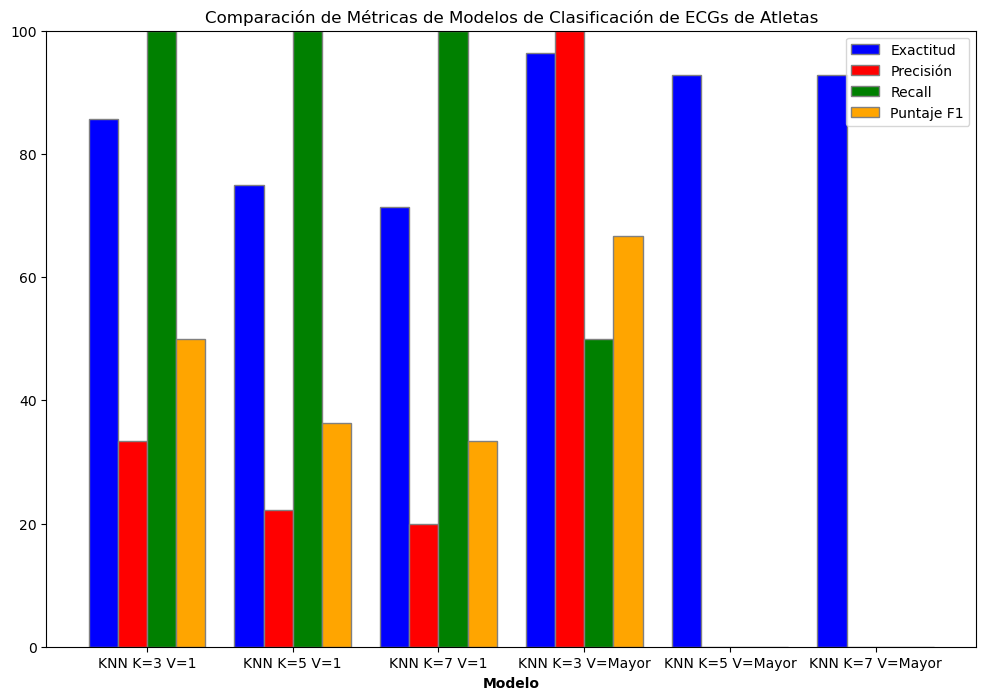

In [79]:
# Obtener las métricas de los modelos
exactitud_K3_v1, precision_K3_v1, recall_K3_v1, f1_K3_v1 = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k3_v1.json')
exactitud_K5_v1, precision_K5_v1, recall_K5_v1, f1_K5_v1 = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k5_v1.json')
exactitud_K7_v1, precision_K7_v1, recall_K7_v1, f1_K7_v1 = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k7_v1.json')

exactitud_K3_vMayor, precision_K3_vMayor, recall_K3_vMayor, f1_K3_vMayor = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k3_vMayor.json')
exactitud_K5_vMayor, precision_K5_vMayor, recall_K5_vMayor, f1_K5_vMayor = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k5_vMayor.json')
exactitud_K7_vMayor, precision_K7_vMayor, recall_K7_vMayor, f1_K7_vMayor = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k7_vMayor.json')

print('Métricas del modelo KNN con K=3 y V=1:')
print(f'Exactitud: {exactitud_K3_v1:.2f}')
print(f'Precisión: {precision_K3_v1:.2f}')
print(f'Recall: {recall_K3_v1:.2f}')
print(f'Puntaje F1: {f1_K3_v1:.2f}')
print()
print('Métricas del modelo KNN con K=5 y V=1:')
print(f'Exactitud: {exactitud_K5_v1:.2f}')
print(f'Precisión: {precision_K5_v1:.2f}')
print(f'Recall: {recall_K5_v1:.2f}')
print(f'Puntaje F1: {f1_K5_v1:.2f}')
print()
print('Métricas del modelo KNN con K=7 y V=1:')
print(f'Exactitud: {exactitud_K7_v1:.2f}')
print(f'Precisión: {precision_K7_v1:.2f}')
print(f'Recall: {recall_K7_v1:.2f}')
print(f'Puntaje F1: {f1_K7_v1:.2f}')
print()
print('Métricas del modelo KNN con K=3 y V=Mayor:')
print(f'Exactitud: {exactitud_K3_vMayor:.2f}')
print(f'Precisión: {precision_K3_vMayor:.2f}')
print(f'Recall: {recall_K3_vMayor:.2f}')
print(f'Puntaje F1: {f1_K3_vMayor:.2f}')
print()
print('Métricas del modelo KNN con K=5 y V=Mayor:')
print(f'Exactitud: {exactitud_K5_vMayor:.2f}')
print(f'Precisión: {precision_K5_vMayor:.2f}')
print(f'Recall: {recall_K5_vMayor:.2f}')
print(f'Puntaje F1: {f1_K5_vMayor:.2f}')
print()
print('Métricas del modelo KNN con K=7 y V=Mayor:')
print(f'Exactitud: {exactitud_K7_vMayor:.2f}')
print(f'Precisión: {precision_K7_vMayor:.2f}')
print(f'Recall: {recall_K7_vMayor:.2f}')
print(f'Puntaje F1: {f1_K7_vMayor:.2f}')

#graficar las metricas
import matplotlib.pyplot as plt

# Crear un gráfico de barras para comparar las métricas
modelos = ['KNN K=3 V=1', 'KNN K=5 V=1', 'KNN K=7 V=1', 'KNN K=3 V=Mayor', 'KNN K=5 V=Mayor', 'KNN K=7 V=Mayor']

plt.figure(figsize=(12, 8))
barWidth = 0.2
r1 = range(len(modelos))

plt.bar(r1, [exactitud_K3_v1 * 100, exactitud_K5_v1 * 100, exactitud_K7_v1 * 100, exactitud_K3_vMayor * 100, exactitud_K5_vMayor * 100, exactitud_K7_vMayor * 100], color='blue', width=barWidth, edgecolor='grey', label='Exactitud')
plt.bar([x + barWidth for x in r1], [precision_K3_v1 * 100, precision_K5_v1 * 100, precision_K7_v1 * 100, precision_K3_vMayor * 100, precision_K5_vMayor * 100, precision_K7_vMayor * 100], color='red', width=barWidth, edgecolor='grey', label='Precisión')
plt.bar([x + barWidth * 2 for x in r1], [recall_K3_v1 * 100, recall_K5_v1 * 100, recall_K7_v1 * 100, recall_K3_vMayor * 100, recall_K5_vMayor * 100, recall_K7_vMayor * 100], color='green', width=barWidth, edgecolor='grey', label='Recall')
plt.bar([x + barWidth * 3 for x in r1], [f1_K3_v1 * 100, f1_K5_v1 * 100, f1_K7_v1 * 100, f1_K3_vMayor * 100, f1_K5_vMayor * 100, f1_K7_vMayor * 100], color='orange', width=barWidth, edgecolor='grey', label='Puntaje F1')

plt.xlabel('Modelo', fontweight='bold')
plt.xticks([r + barWidth * 1.5 for r in range(len(modelos))], modelos)
plt.legend()
plt.title('Comparación de Métricas de Modelos de Clasificación de ECGs de Atletas')
plt.ylim(0, 100)
plt.show()




In [53]:
# Obtener las métricas de los modelos
exactitud_K3_v1, precision_K3_v1, recall_K3_v1, f1_K3_v1 = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k3_v1.json', True)
exactitud_K5_v1, precision_K5_v1, recall_K5_v1, f1_K5_v1 = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k5_v1.json', True)
exactitud_K7_v1, precision_K7_v1, recall_K7_v1, f1_K7_v1 = obtener_metricas(etiquetaRiesgoDeportista, 'diagnosticos_ecgs_k7_v1.json', True)

print('Métricas del modelo KNN con K=3 y V=1:')
print(f'Exactitud: {exactitud_K3_v1:.2f}')
print(f'Precisión: {precision_K3_v1:.2f}')
print(f'Recall: {recall_K3_v1:.2f}')
print(f'Puntaje F1: {f1_K3_v1:.2f}')
print()
print('Métricas del modelo KNN con K=5 y V=1:')
print(f'Exactitud: {exactitud_K5_v1:.2f}')
print(f'Precisión: {precision_K5_v1:.2f}')
print(f'Recall: {recall_K5_v1:.2f}')
print(f'Puntaje F1: {f1_K5_v1:.2f}')
print()
print('Métricas del modelo KNN con K=7 y V=1:')
print(f'Exactitud: {exactitud_K7_v1:.2f}')
print(f'Precisión: {precision_K7_v1:.2f}')
print(f'Recall: {recall_K7_v1:.2f}')
print(f'Puntaje F1: {f1_K7_v1:.2f}')
print()



Métricas del modelo KNN con K=3 y V=1:
Exactitud: 0.96
Precisión: 0.83
Recall: 1.00
Puntaje F1: 0.91

Métricas del modelo KNN con K=5 y V=1:
Exactitud: 0.96
Precisión: 0.89
Recall: 1.00
Puntaje F1: 0.94

Métricas del modelo KNN con K=7 y V=1:
Exactitud: 0.93
Precisión: 0.80
Recall: 1.00
Puntaje F1: 0.89

